### Goal 

Predict a movie that someone will like depending on what they have liked before

### Direction
Score prediction from 1->5

### Steps

1. Merge dataset to derive a userId - movie details - ratings  mapping
& Unwrap all nested values + OHE stuff
2. Select userIds with more than a certain number of ratings
3. Analyze the relationships between the movies and the ratings
4. Build model based on relationships
5. Create a flexible model that utilizes multiple users

### Features to add given contextual knowledge
1. Theme
2. Box office
3. Actors
4. Directors
5. Key words

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
import datetime
from sklearn.preprocessing import MultiLabelBinarizer
import json

from scipy.stats import norm, gamma, expon
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

In [25]:
with open("countryCode.json", "r") as json_file:
    # Load the JSON data
    countryCode = json.load(json_file)

In [60]:
merged_df = pd.read_csv('merged_dfs.csv')

Convert into the right data types

In [61]:
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'])

#convert to the right data type
merged_df['genres'] = merged_df['genres'].apply(ast.literal_eval)
merged_df['production_companies'] = merged_df['production_companies'].apply(ast.literal_eval)
merged_df['production_countries'] = merged_df['production_countries'].apply(ast.literal_eval)
merged_df['spoken_languages'] = merged_df['spoken_languages'].apply(ast.literal_eval)
merged_df['director'] = merged_df['director'].apply(ast.literal_eval)
merged_df['cast'] = merged_df['cast'].apply(ast.literal_eval)
merged_df['keywords_id'] = merged_df['keywords_id'].apply(ast.literal_eval)

#replace empty arrays
merged_df['director'] = merged_df['director'].apply(lambda x : "unnamed" if len(x) == 0 else x)

#convert the dictionaries into arrays of ids
merged_df['cast'] = merged_df['cast'].apply(lambda x: x[0:5])
merged_df['director'] = merged_df['director'].apply(lambda x: x[0:5])
merged_df['production_countries_name'] = merged_df['production_countries'].apply(lambda x : [item["iso_3166_1"] for item in x] if isinstance(x, list) else [])
merged_df['spoken_languages_name'] = merged_df['spoken_languages'].apply(lambda x : [item["iso_639_1"] for item in x] if isinstance(x, list) else [])

merged_df['production_companies_name'] = merged_df['production_companies'].apply(lambda x : [item["name"] for item in x] if isinstance(x, list) else [])
merged_df['genre_name'] = merged_df['genres'].apply(lambda x : [item["name"] for item in x] if isinstance(x, list) else [])

Binarize the data

In [177]:
#binarize variables
oneDs = merged_df[merged_df['userId'] == 45811]

#reduce dimension by binning
def map_country_codes_to_countries(country_codes):
    return [countryCode[code] for code in country_codes if code in countryCode]
oneDs['production_countries_name'] = oneDs['production_countries_name'].apply(lambda x : map_country_codes_to_countries(x))
mlb = MultiLabelBinarizer()
OHE = mlb.fit_transform(oneDs['production_countries_name'])
OHE = pd.DataFrame(OHE)
prefix = "ProdCountry_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
majorLanguages = ["ar", "zh", "en", "fr", "ru", "es"]
oneDs["spoken_languages_name"] = oneDs['spoken_languages_name'].replace(np.NaN, "")
def map_languages(languages):
    if any(language in majorLanguages for language in languages):
        return [language if language in majorLanguages else "others" for language in languages]
    else:
        return ["others"]

#reduce dimension by binning
oneDs['spoken_languages_name'] = oneDs['spoken_languages_name'].apply(map_languages)
OHE = mlb.fit_transform(oneDs['spoken_languages_name'])
OHE = pd.DataFrame(OHE)
prefix = "SpokenLang_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
oneDs["production_companies_name"] = oneDs['production_companies_name'].replace(np.NaN, "")
OHE = mlb.fit_transform(oneDs['production_companies_name'])
OHE = pd.DataFrame(OHE)
prefix = "ProdCompany_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
oneDs["genre_name"] = oneDs['genre_name'].replace(np.NaN, "")
OHE = mlb.fit_transform(oneDs['genre_name'])
OHE = pd.DataFrame(OHE)
prefix = "Genre_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
OHE = mlb.fit_transform(oneDs['cast'])
OHE = pd.DataFrame(OHE)
prefix = "Cast_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
OHE = mlb.fit_transform(oneDs['director'])
OHE = pd.DataFrame(OHE)
prefix = "Director_"
prefixed_strings = list(map(lambda s: prefix + s, mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

mlb = MultiLabelBinarizer()
OHE = mlb.fit_transform(oneDs['keywords_id'])
OHE = pd.DataFrame(OHE)
prefix = "kw_"
prefixed_strings = list(map(lambda s: prefix + str(s), mlb.classes_))
OHE.columns = prefixed_strings
oneDs = pd.concat([oneDs.reset_index(drop=True), OHE], axis=1)

oneDs.head()

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,kw_238591,kw_238592,kw_238593,kw_238594,kw_238595,kw_238596,kw_238597,kw_238821,kw_238847,kw_238848
0,45811,4.5,True,21000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858,tt0108160,en,A young boy who tries to set his dad up on a d...,10.234919,...,0,0,0,0,0,0,0,0,0,0
1,45811,4.0,True,24000000,"[{'id': 18, 'name': 'Drama'}]",1246,tt0479143,en,When he loses a highly publicized virtual boxi...,11.697604,...,0,0,0,0,0,0,0,0,0,0
2,45811,3.5,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",1968,tt0119141,en,Alex Whitman (Matthew Perry) is a designer fro...,6.285574,...,0,0,0,0,0,0,0,0,0,0
3,45811,4.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2762,tt0029811,en,Derrick De Marney finds himself in a 39 Steps ...,3.824884,...,0,0,0,0,0,0,0,0,0,0
4,45811,3.5,True,35000000,"[{'id': 35, 'name': 'Comedy'}]",2959,tt0762114,en,"Newly engaged, Ben and Sadie can't wait to sta...",7.102076,...,0,0,0,0,0,0,0,0,0,0


Reduce the dimension of the sparse matrix by using more frequently used variables

In [178]:
bottomPercent = 0.9
colVars = [col for col in oneDs.columns if col.startswith("kw_")]
bottomFrequentKw = oneDs[colVars].sum().sort_values(ascending=True).head(int(len(oneDs) * bottomPercent)).index.tolist()
oneDs.drop(bottomFrequentKw,axis=1,inplace=True)

bottomPercent = 0.9
colVars = [col for col in oneDs.columns if col.startswith("Cast_")]
bottomFrequentCast = oneDs[colVars].sum().sort_values(ascending=True).head(int(len(oneDs) * bottomPercent)).index.tolist()
oneDs.drop(bottomFrequentCast,axis=1,inplace=True)

bottomPercent = 0.9
colVars = [col for col in oneDs.columns if col.startswith("Director_")]
bottomFrequentDirector = oneDs[colVars].sum().sort_values(ascending=True).head(int(len(oneDs) * bottomPercent)).index.tolist()
oneDs.drop(bottomFrequentDirector,axis=1,inplace=True)

bottomPercent = 0.9
colVars = [col for col in oneDs.columns if col.startswith("ProdCompany_")]
bottomFrequentProdCompany = oneDs[colVars].sum().sort_values(ascending=True).head(int(len(oneDs) * bottomPercent)).index.tolist()
oneDs.drop(bottomFrequentProdCompany,axis=1,inplace=True)

In [180]:
len(oneDs.columns)

7080

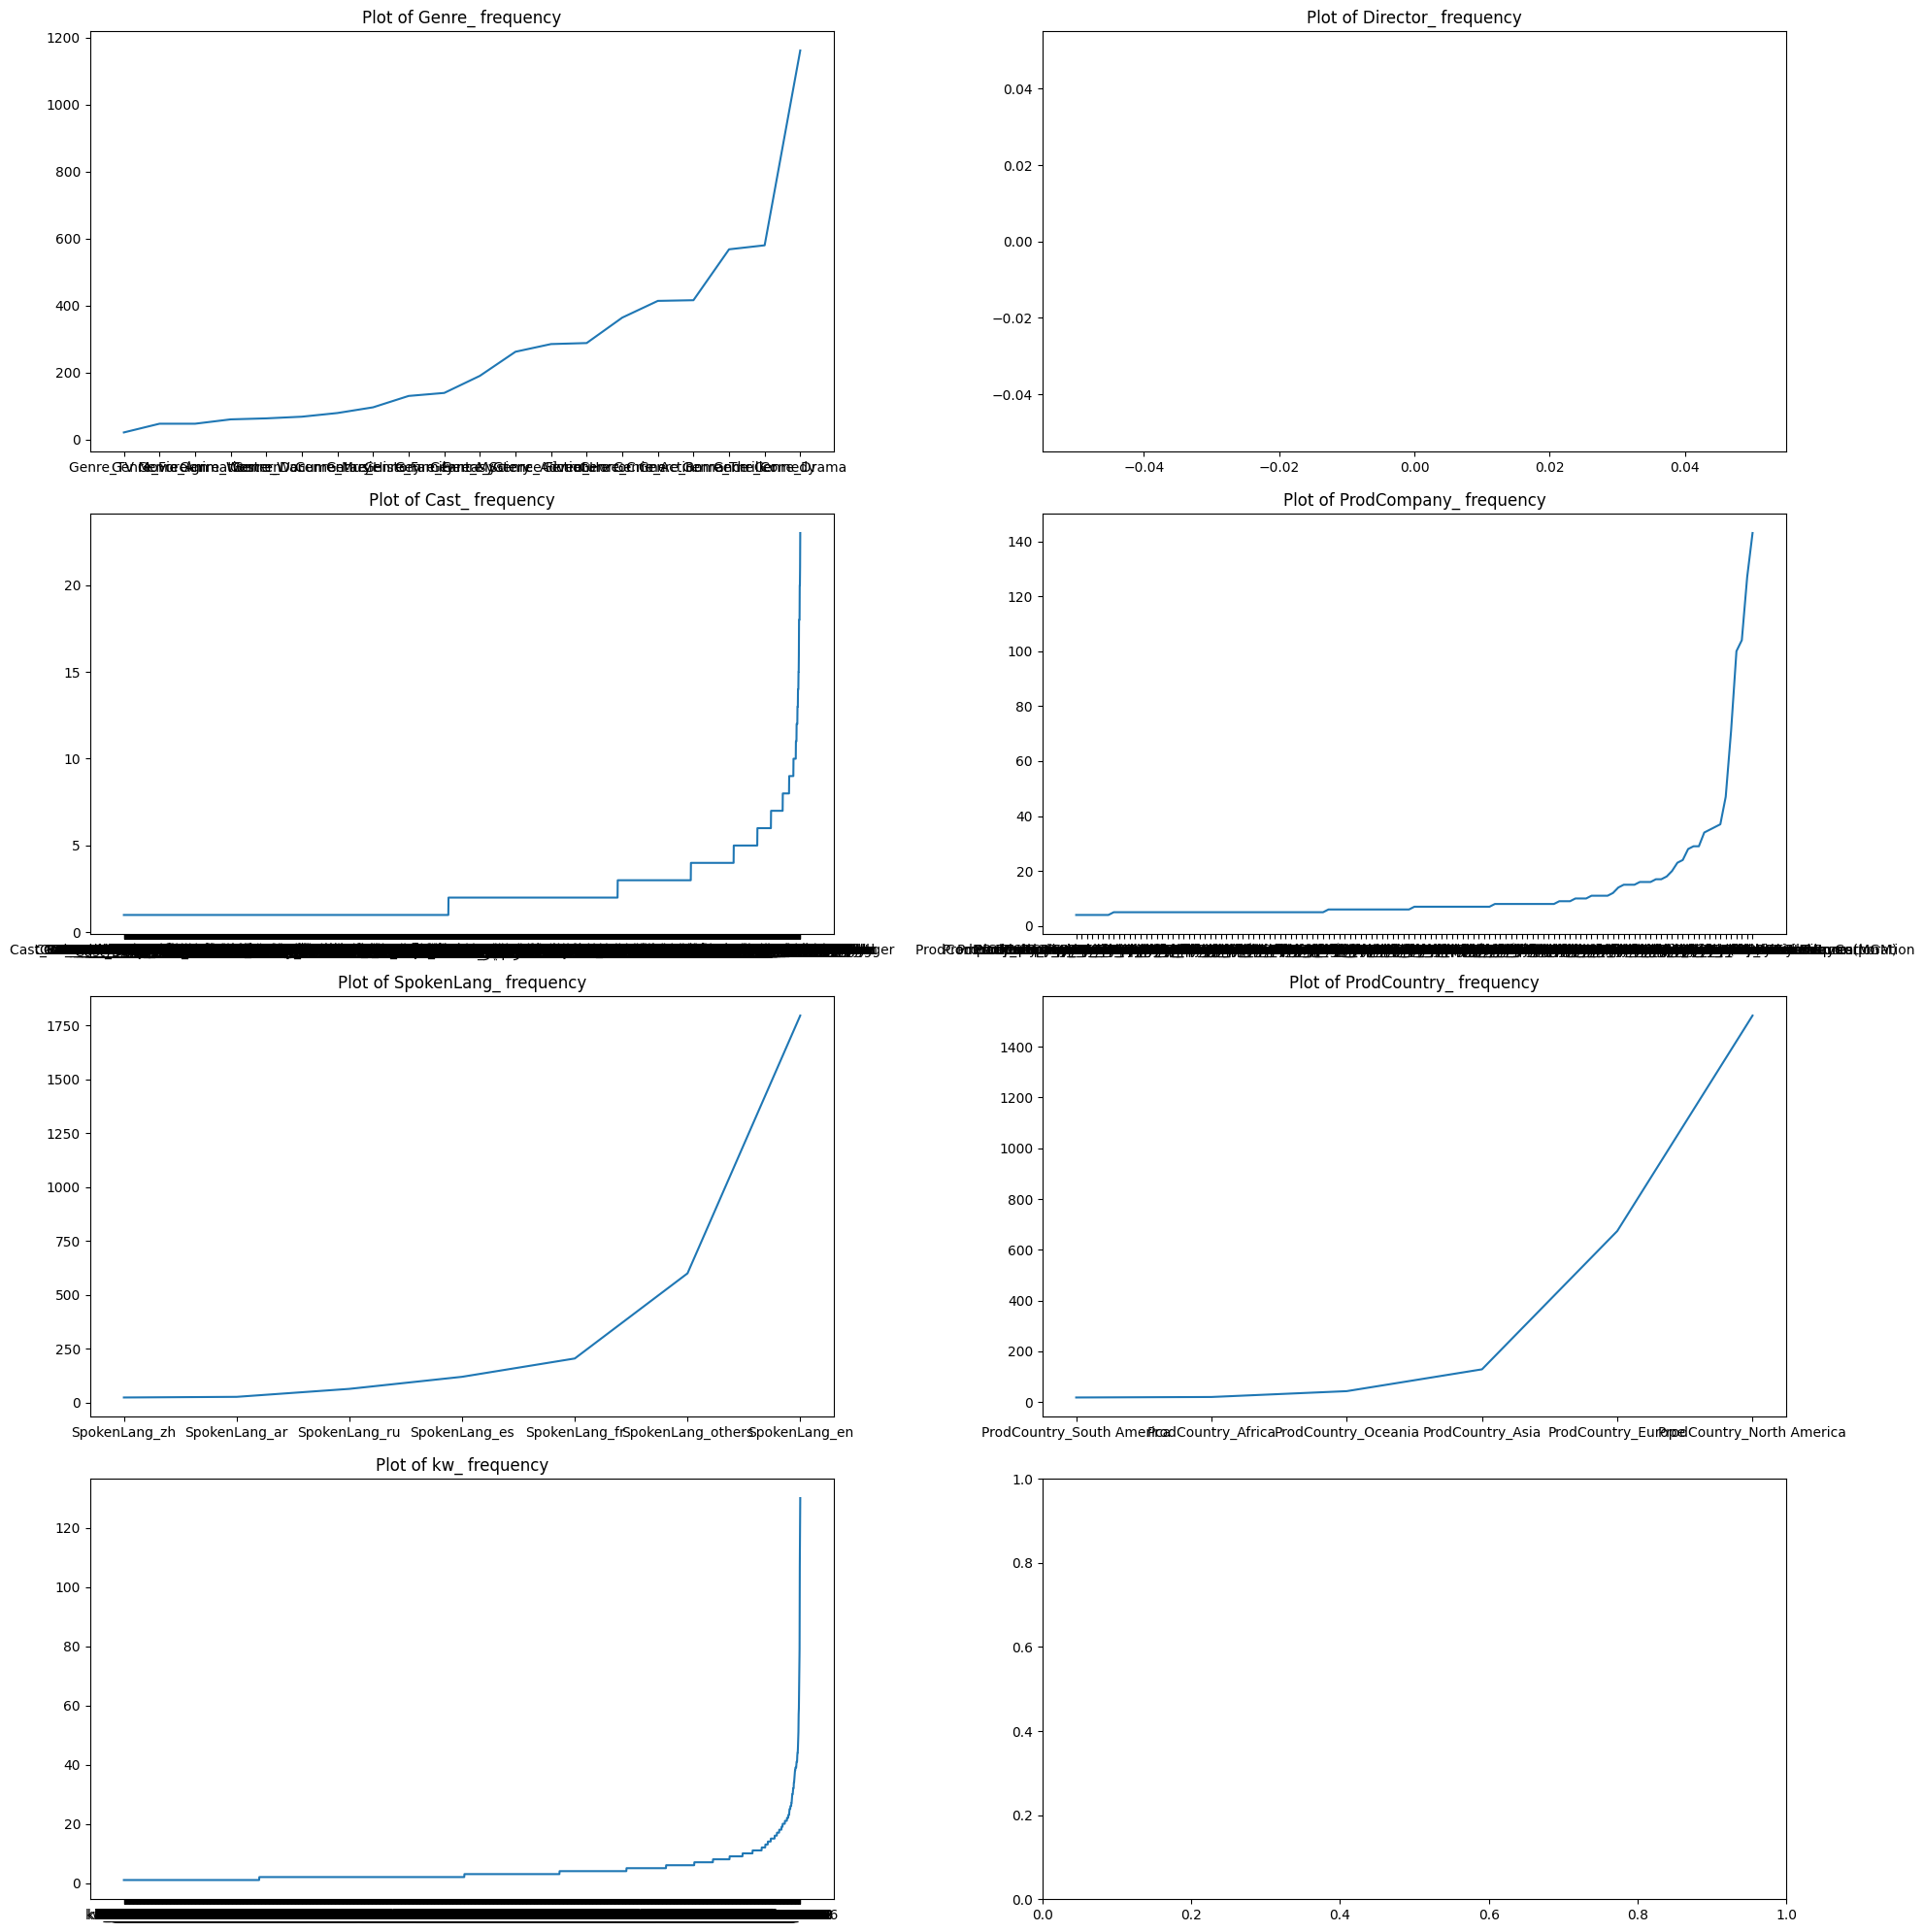

In [181]:
prefixVars = ['Genre_', 'Director_', 'Cast_', 'ProdCompany_', 'SpokenLang_', 'ProdCountry_', 'kw_']

fig, axes = plt.subplots(4, 2, figsize=(20, 20))

for i, prefix in enumerate(prefixVars):
    colVars = [col for col in oneDs.columns if col.startswith(prefix)]
    ax = axes[i // 2, i % 2]
    ax.plot(oneDs[colVars].sum().sort_values())
    ax.set_title(f"Plot of {prefix} frequency")

plt.tight_layout()
plt.show()

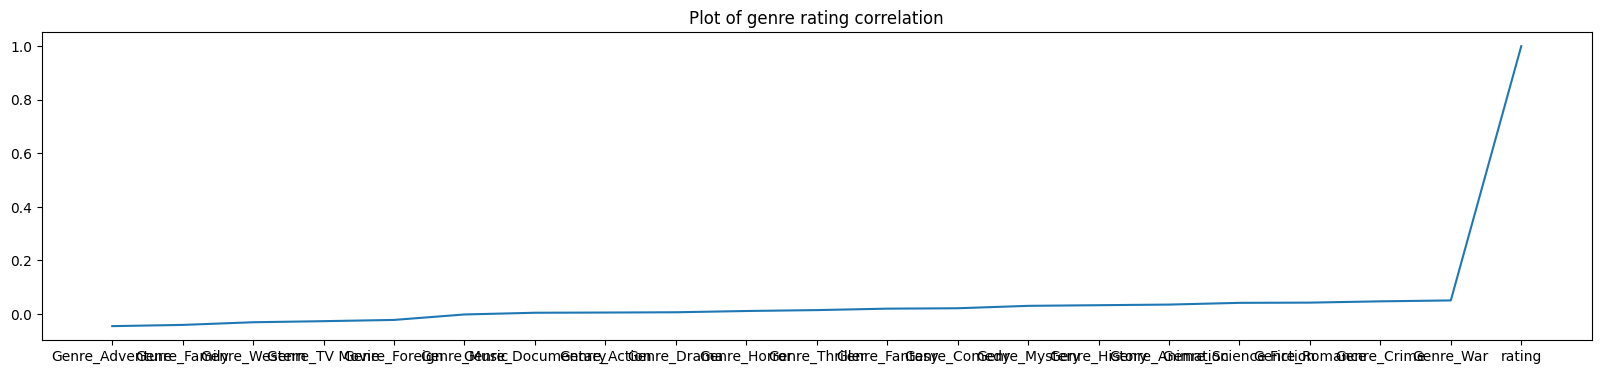

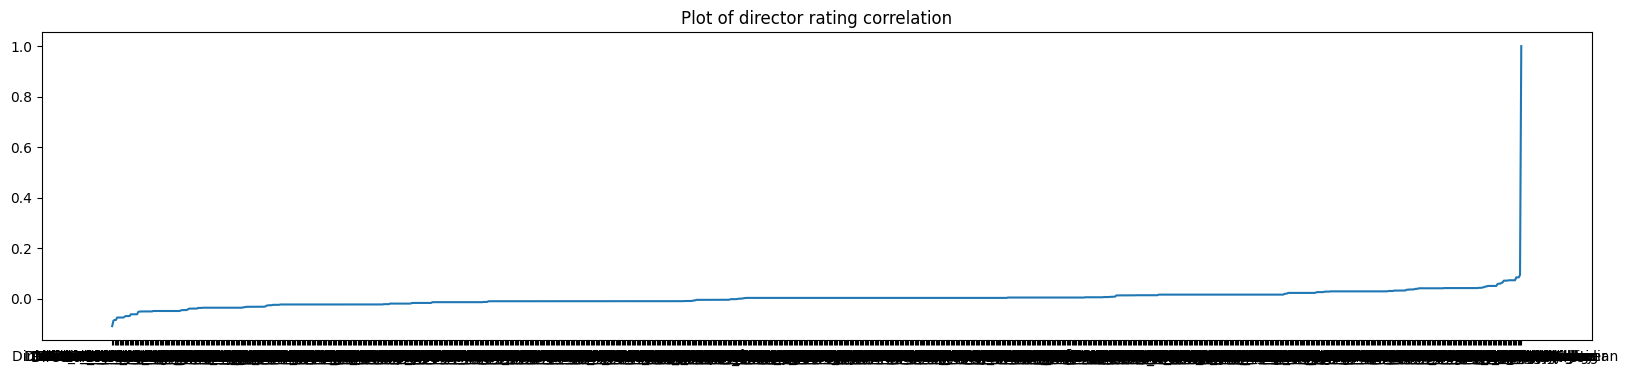

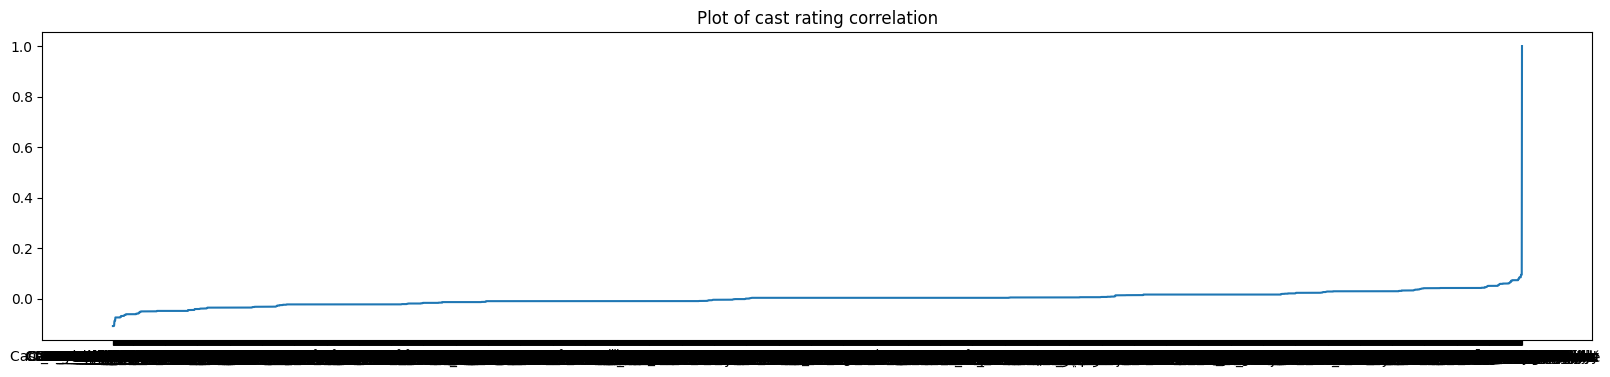

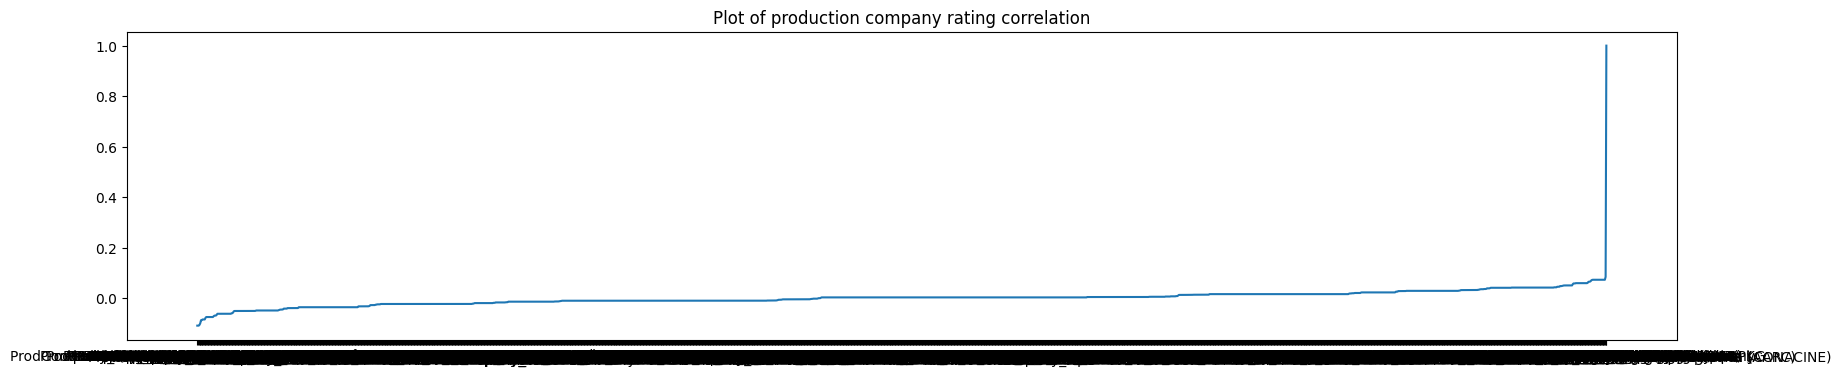

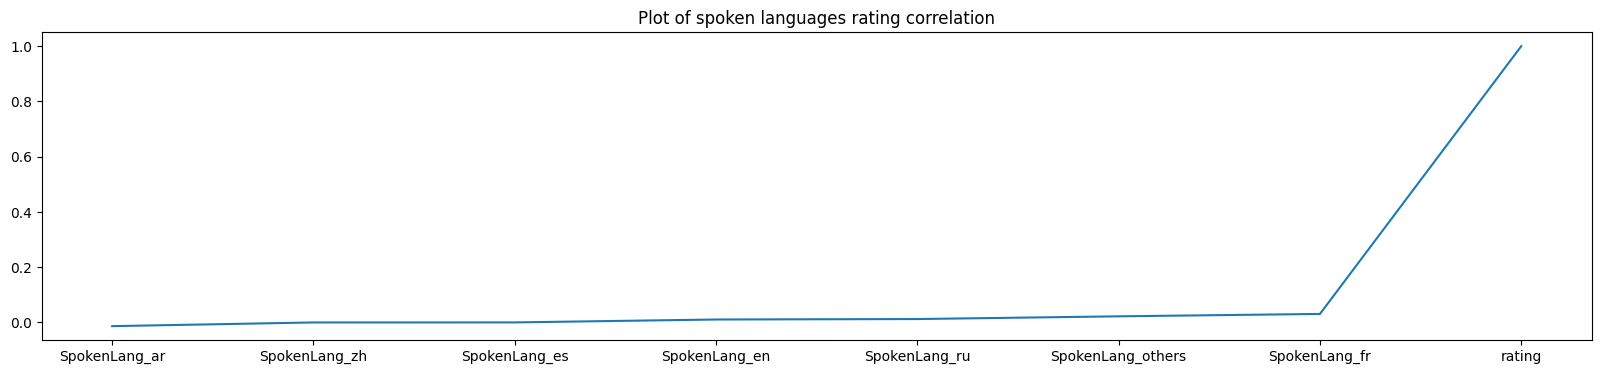

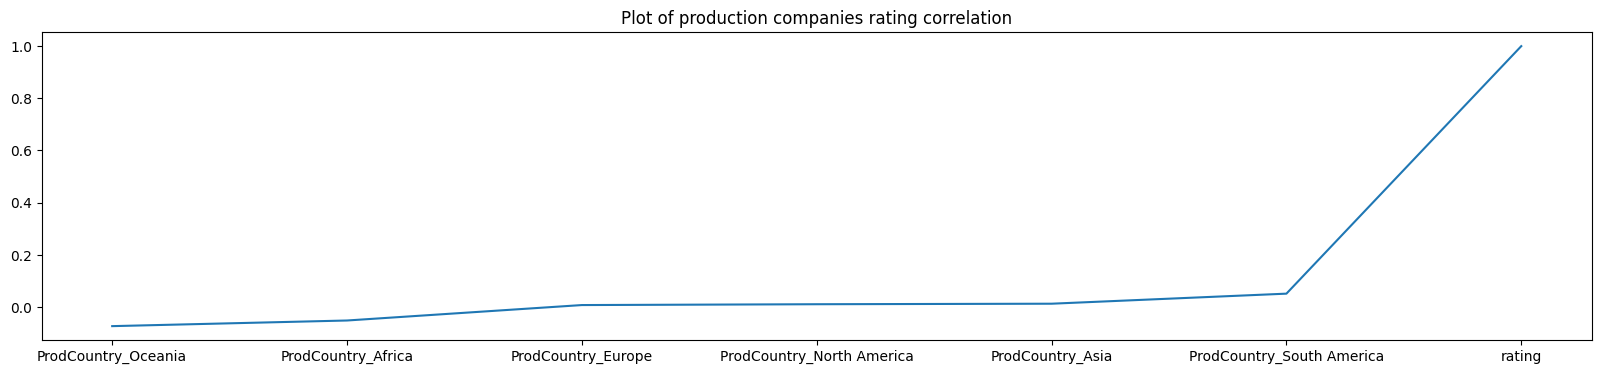

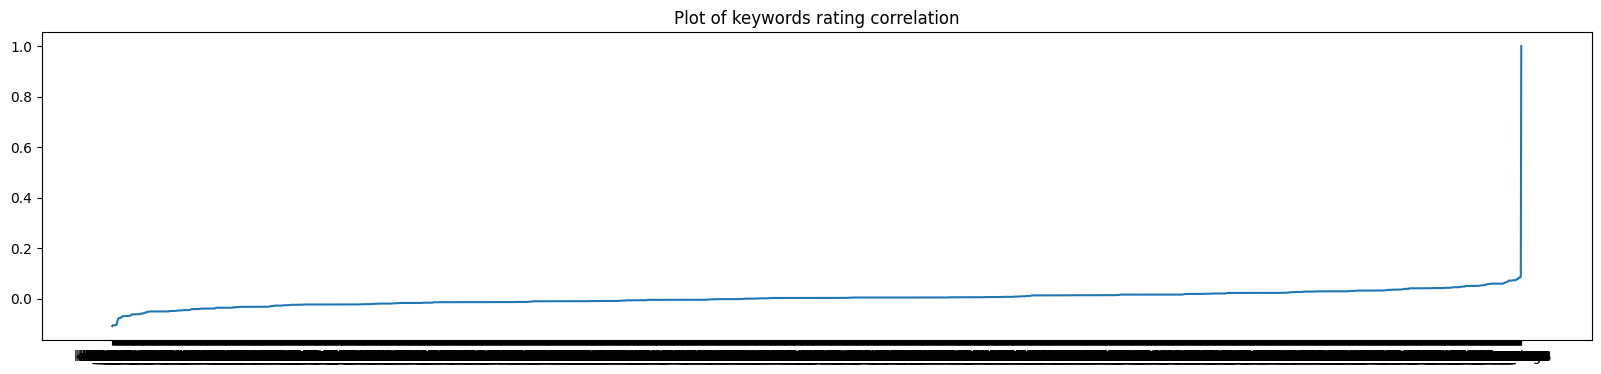

In [106]:
colVars = [col for col in oneDs.columns if col.startswith("Genre_")]
colVars.append("rating")
genreRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of genre rating correlation")
plt.plot(genreRatingCorr.sort_values())
plt.show()

colVars = [col for col in oneDs.columns if col.startswith("Director_")]
colVars.append("rating")
directorRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of director rating correlation")
plt.plot(directorRatingCorr.sort_values())
plt.show()

colVars = [col for col in oneDs.columns if col.startswith("Cast_")]
colVars.append("rating")
castRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of cast rating correlation")
plt.plot(castRatingCorr.sort_values())
plt.show()

colVars = [col for col in oneDs.columns if col.startswith("ProdCompany_")]
colVars.append("rating")
prodCompRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of production company rating correlation")
plt.plot(prodCompRatingCorr.sort_values())
plt.show()

colVars = [col for col in oneDs.columns if col.startswith("SpokenLang_")]
colVars.append("rating")
spokenLangRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of spoken languages rating correlation")
plt.plot(spokenLangRatingCorr.sort_values())
plt.show()

colVars = [col for col in oneDs.columns if col.startswith("ProdCountry_")]
colVars.append("rating")
prodCountryRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of production companies rating correlation")
plt.plot(prodCountryRatingCorr.sort_values())
plt.show()

colVars = [col for col in oneDs.columns if col.startswith("kw_")]
colVars.append("rating")
kwRatingCorr = oneDs[colVars].corr()['rating']
plt.figure(figsize=(20,4))
plt.title("Plot of keywords rating correlation")
plt.plot(kwRatingCorr.sort_values())
plt.show()

Prepare the data for modelling

In [224]:
oneDs['release_date'] = pd.to_datetime(oneDs['release_date'])
oneDs['release_date_timestamp'] = oneDs['release_date'].apply(lambda x : x.timestamp())
prefixVars = ['Genre_','Director_','Cast_', 'ProdCompany_', 'SpokenLang_', 'ProdCountry_', 'kw_']

selected_col = [col for col in oneDs.columns if any(col.startswith(prefix) for prefix in prefixVars)]
oneDs[selected_col] = oneDs[selected_col].replace(np.NaN, 0)
oneDs['likeMovie'] = oneDs['rating'] >= 4
oneDs.head()
#allVars = ['rating', 'adult', 'budget', 'popularity', 'revenue', 'runtime', 'release_date_timestamp', 'vote_average', 'vote_count', 'average_sentiment'] + selected_col
allPossibleVars = ['adult', 'average_sentiment'] + selected_col
#Select columns
#corrMat = oneDs[allVars].corr()

scaler = StandardScaler()
columns_to_normalize = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'release_date_timestamp']
normalized_data = scaler.fit_transform(oneDs[columns_to_normalize])
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize)

## ML creation
1. Predict the rating of a movie
2. Predict if the rating of a movie is above 4

In [225]:
#import ML models
#linear  models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA

#categorization models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, BaggingClassifier

### TODO 
To grid search on ensemble methods?

To plot a PCA graph

In [223]:
X

,adult,release_date_timestamp,average_sentiment,ProdCountry_Africa,ProdCountry_Asia,ProdCountry_Europe,ProdCountry_North America,ProdCountry_Oceania,ProdCountry_South America,SpokenLang_ar,...,kw_238595,kw_238596,kw_238597,kw_238821,budget,popularity,revenue,runtime,vote_average,vote_count
0,True,7.408800e+08,0.179658,0,0,0,1,0,0,0,...,0,0,0,0,0.331052,0.717510,1.575817,0.083516,0.303855,0.322200
1,True,1.166573e+09,0.161213,0,0,0,1,0,0,0,...,0,0,0,0,0.437976,0.930585,0.977627,-0.017798,0.303855,0.573072
2,True,8.558784e+08,0.063483,0,0,0,1,0,0,0,...,0,0,0,0,-0.417419,0.142195,-0.070051,0.218602,-0.163551,-0.224657
3,True,-1.015114e+09,0.087360,0,0,1,0,0,0,0,...,0,0,0,0,-0.417419,-0.216263,-0.314721,-0.659454,0.504171,-0.324786
4,True,1.183507e+09,0.072975,0,0,0,1,1,0,0,...,0,0,0,0,0.830033,0.261138,0.260468,-0.389283,-0.497412,-0.087118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,True,1.309392e+09,0.000000,0,0,0,1,0,0,0,...,0,0,0,0,-0.417419,-0.619234,-0.314721,-0.828310,-2.367034,-0.368799
2199,True,1.377216e+09,0.292698,0,0,0,1,0,0,0,...,0,0,0,0,-0.417419,0.023659,-0.314721,-0.591911,0.103538,-0.280773
2200,True,1.362787e+09,0.172345,0,0,0,1,0,0,0,...,0,0,0,0,-0.417419,-0.645587,-0.314721,-1.368652,0.303855,-0.354495
2201,True,-5.071680e+08,0.120140,0,0,0,1,0,0,0,...,0,0,0,0,-0.417419,-0.750360,-0.314721,-1.301109,1.305438,-0.369899


In [226]:
#categorical classifier
X = pd.concat([oneDs[allPossibleVars], normalized_df], axis = 1)
y = oneDs['likeMovie']

#transformer = SparsePCA(n_components=30, random_state=0)
#transformer.fit(X)
#X = transformer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

gnb = GaussianNB().fit(X_train, y_train)
clfSvm = SVC().fit(X_train, y_train)
clfTree = DecisionTreeClassifier().fit(X_train, y_train)
neigh = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)

print("\nKNN:",  classification_report(y_test, neigh.predict(X_test)))
print("\nDTree: ", classification_report(y_test, clfTree.predict(X_test)))
print("\nSVM: ", classification_report(y_test, clfSvm.predict(X_test)))
print("\nNB: ", classification_report(y_test, gnb.predict(X_test)))


KNN:               precision    recall  f1-score   support

       False       0.73      0.92      0.81       396
        True       0.38      0.13      0.19       155

    accuracy                           0.70       551
   macro avg       0.56      0.52      0.50       551
weighted avg       0.63      0.70      0.64       551


DTree:                precision    recall  f1-score   support

       False       0.80      0.87      0.83       396
        True       0.58      0.44      0.50       155

    accuracy                           0.75       551
   macro avg       0.69      0.66      0.67       551
weighted avg       0.74      0.75      0.74       551


SVM:                precision    recall  f1-score   support

       False       0.77      1.00      0.87       396
        True       1.00      0.22      0.36       155

    accuracy                           0.78       551
   macro avg       0.88      0.61      0.61       551
weighted avg       0.83      0.78      0.72       55

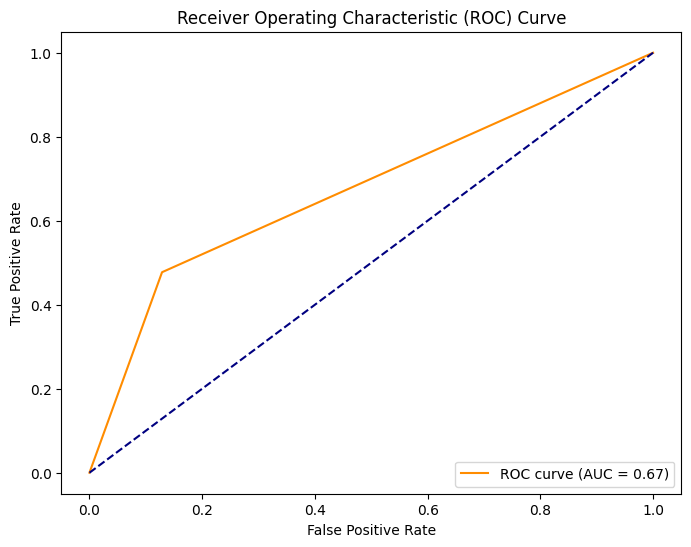

In [191]:
y_pred_proba = clfTree.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Stacking classifier

In [227]:
estimators = [
('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
('svr', make_pipeline(StandardScaler(),
LinearSVC(dual="auto", random_state=42))),
('dt',DecisionTreeClassifier()),
]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
print("\nNB: ", classification_report(y_test, clf.predict(X_test)))


NB:                precision    recall  f1-score   support

       False       0.80      0.96      0.87       396
        True       0.77      0.37      0.50       155

    accuracy                           0.79       551
   macro avg       0.78      0.67      0.69       551
weighted avg       0.79      0.79      0.77       551



In [116]:
clf

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(dual='auto',
                                                           random_state=42))])),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

### Bagging classifier

In [228]:
clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=1, random_state=0).fit(X_train, y_train)
print("\nNB: ", classification_report(y_test, clf.predict(X_test)))


NB:                precision    recall  f1-score   support

       False       0.78      0.84      0.81       396
        True       0.49      0.38      0.43       155

    accuracy                           0.71       551
   macro avg       0.63      0.61      0.62       551
weighted avg       0.70      0.71      0.70       551



## For the case of regression

In [ ]:
#Linear regression
X = pd.concat([oneDs[allPossibleVars], normalized_df], axis = 1)
y = oneDs['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
clfLasso = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
clfRidge = Ridge(alpha=1.0).fit(X, y)

#lasso
print("Lasso regression")
y_pred = clfLasso.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
print(" ")
#ridge
print("Ridge regression")
y_pred = clfRidge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

#
print(" ")
#ridge
print("Unregularised regression")
y_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Lasso regression
Mean Absolute Error: 0.8240014984935169
Mean Squared Error: 1.0452143791688235
Root Mean Squared Error: 1.0223572659148188
R² Score: -0.013307746810573562
 
Ridge regression
Mean Absolute Error: 0.8451026906892176
Mean Squared Error: 1.0758004696191619
Root Mean Squared Error: 1.0372080165613655
R² Score: -0.0429601540254676
 
Unregularised regression
Mean Absolute Error: 0.7147591814565523
Mean Squared Error: 1.2945502424055595
Root Mean Squared Error: 1.137783038371358
R² Score: -0.255032283719836
